In [ ]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 22.1 MB/s eta 0:00:00


In [ ]:
import fitz
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import resize
from imageio import imread

# Step 1: Convert the first page of a PDF to a PNG image using fitz
def convert_pdf_to_image(pdf_path, output_folder):
    doc = fitz.open(pdf_path)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    page = doc.load_page(0)  # Load the first page (index 0)
    pix = page.get_pixmap()
    image_path = os.path.join(output_folder, f"{pdf_path[9:20]}_page_1.png")
    pix.save(image_path)
    doc.close()
    return image_path

# pdf_path = "bleed-through-text.pdf"
pdf_path = "porcones-test.pdf"
output_folder = "output_folder"
image_path = convert_pdf_to_image(pdf_path, output_folder)


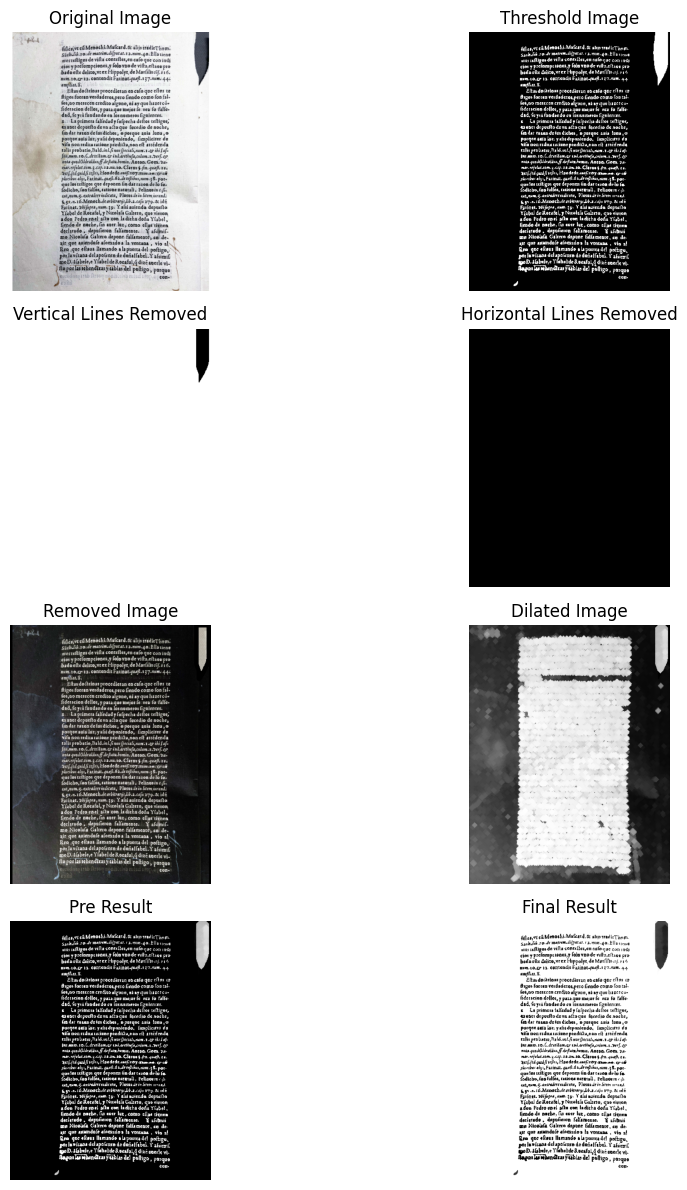

True

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('/content/1.png')
# image = cv2.imread('/content/2.jpeg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray = cv2.fastNlMeansDenoising(gray, None, 30, 7, 21)

# Apply binary thresholding using Otsu's method
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]


# Copy the original image to preserve it
removed = image.copy()

# Remove vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
remove_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(removed, [c], -1, (255, 255, 255), 7)

# Remove horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
remove_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(removed, [c], -1, (255, 255, 255), 5)

# Repair kernel
repair_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
removed = 255 - removed
dilate = cv2.dilate(removed, repair_kernel, iterations=5)
dilate = cv2.cvtColor(dilate, cv2.COLOR_BGR2GRAY)
pre_result = cv2.bitwise_and(dilate, thresh)

# Final result
result = cv2.morphologyEx(pre_result, cv2.MORPH_CLOSE, repair_kernel, iterations=5)
final = cv2.bitwise_and(result, thresh)

# Invert the final image
invert_final = 255 - final

# Plotting each step
fig, axes = plt.subplots(4, 2, figsize=(12, 12))
axes = axes.flatten()

axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(thresh, cmap='gray')
axes[1].set_title('Threshold Image')
axes[1].axis('off')

axes[2].imshow(255 - remove_vertical, cmap='gray')
axes[2].set_title('Vertical Lines Removed')
axes[2].axis('off')

axes[3].imshow(255 - remove_horizontal, cmap='gray')
axes[3].set_title('Horizontal Lines Removed')
axes[3].axis('off')

axes[4].imshow(cv2.cvtColor(removed, cv2.COLOR_BGR2RGB))
axes[4].set_title('Removed Image')
axes[4].axis('off')

axes[5].imshow(dilate, cmap='gray')
axes[5].set_title('Dilated Image')
axes[5].axis('off')

axes[6].imshow(pre_result, cmap='gray')
axes[6].set_title('Pre Result')
axes[6].axis('off')

axes[7].imshow(invert_final, cmap='gray')
axes[7].set_title('Final Result')
axes[7].axis('off')

plt.tight_layout()
plt.show()

# Save the final image
cv2.imwrite('final_result.png', invert_final)
cv2.imwrite('thresh.png', (255-thresh))



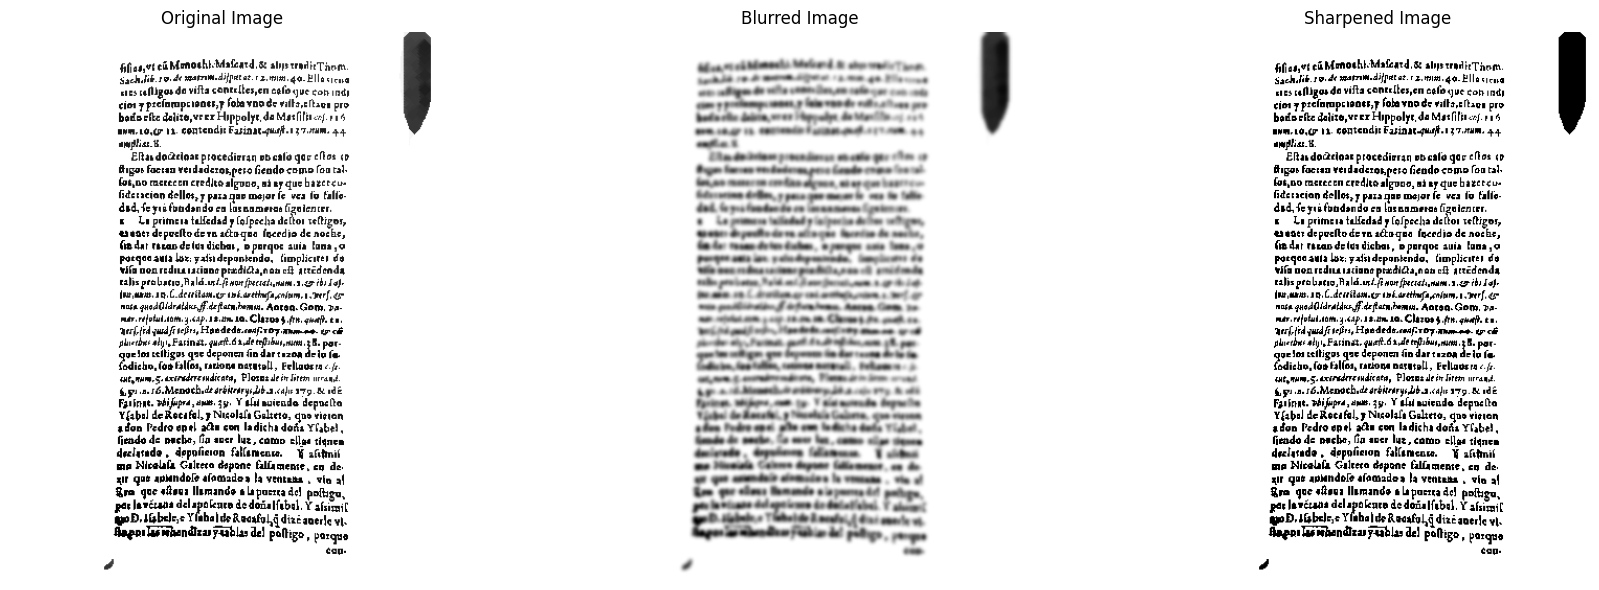

True

In [ ]:
# Apply Gaussian Blur to create an unsharp mask
gaussian_blur = cv2.GaussianBlur(invert_final, (9, 9), 0)

# Sharpen image by subtracting the blurred image from the original
sharpened = cv2.addWeighted(invert_final, 1.5, gaussian_blur, -0.5, 0)

# Optional: Apply threshold to maintain a clear binary image
_, sharpened_thresh = cv2.threshold(sharpened, 127, 255, cv2.THRESH_BINARY)

# Display the images for comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(invert_final, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(gaussian_blur, cmap='gray')
axes[1].set_title('Blurred Image')
axes[1].axis('off')

axes[2].imshow(sharpened_thresh, cmap='gray')
axes[2].set_title('Sharpened Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Save the sharpened image for OCR
output_path_sharpened = 'sharpened_ocr_ready_image.png'
cv2.imwrite(output_path_sharpened, sharpened_thresh)

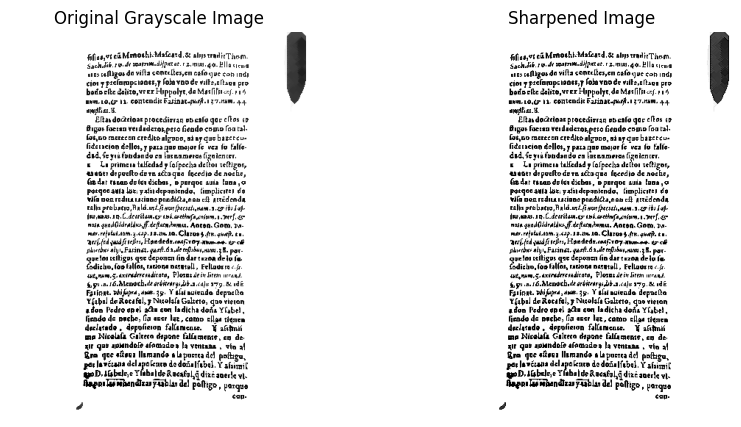

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/final_result.png'
image = cv2.imread(image_path)

# Check if image is loaded properly
if image is None:
    raise ValueError("Image not found or the path is incorrect")

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Define the sharpening kernel
sharpening_kernel = np.array([[0, -1, 0],
                              [-1, 5,-1],
                              [0, -1, 0]])

# Applying the sharpening kernel to the grayscale image
sharpened_image = cv2.filter2D(gray_image, -1, sharpening_kernel)

# Displaying the original and sharpened images using Matplotlib
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB))
ax[0].title.set_text('Original Grayscale Image')
ax[0].axis('off')

ax[1].imshow(cv2.cvtColor(sharpened_image, cv2.COLOR_GRAY2RGB))
ax[1].title.set_text('Sharpened Image')
ax[1].axis('off')

plt.show()

# Save the sharpened image for OCR
output_path_sharpened = 'sharpened_ocr_ready_image1.png'
cv2.imwrite(output_path_sharpened, sharpened_image)


True

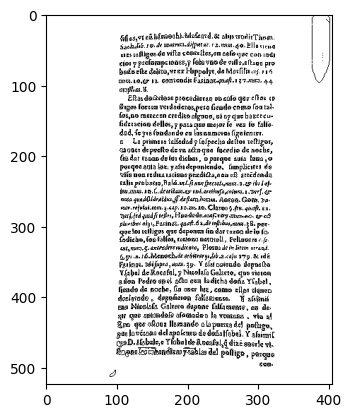

In [ ]:
img = cv2.imread('/content/sharpened_ocr_ready_image1.png')
h, w = img.shape[0],img.shape[1]
kernel = np.ones((7, 7), np.uint8)
dilation = cv2.dilate(img, kernel, iterations=1)
# blurred_dilation = cv2.GaussianBlur(dilation, (13, 13), 0)
resized = cv2.resize(dilation, (w, h))
corrected = img / resized * 255
plt.imshow(corrected)

output_path_sharpened = 'img.png'
cv2.imwrite(output_path_sharpened, corrected)

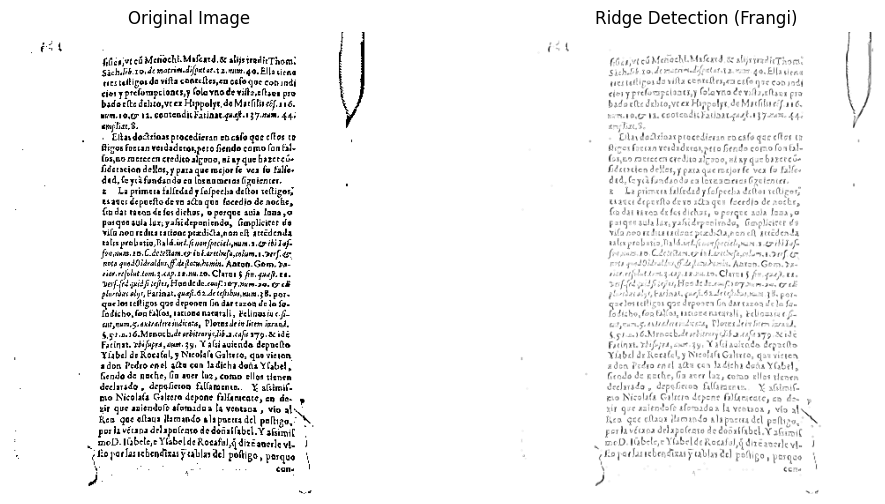

In [ ]:
import cv2
import numpy as np
from skimage.filters import frangi
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/sharpened_ocr_ready_image.png'
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Normalize the image
normalized_image = cv2.normalize(gray_image, None, 0, 255, cv2.NORM_MINMAX)

# Apply Frangi filter for ridge detection
frangi_image = 255 - frangi(normalized_image)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(gray_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Ridge Detection (Frangi)')
plt.imshow(frangi_image, cmap='gray')
plt.axis('off')

plt.show()


In [ ]:
import math
from typing import Tuple, Union

import cv2
import numpy as np

from deskew import determine_skew


def rotate(
        image: np.ndarray, angle: float, background: Union[int, Tuple[int, int, int]]
) -> np.ndarray:
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)

image = cv2.imread('/content/sharpened_ocr_ready_image.png')
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
angle = determine_skew(grayscale)
rotated = rotate(image, angle, (0, 0, 0))
cv2.imwrite('output.png', rotated)

True

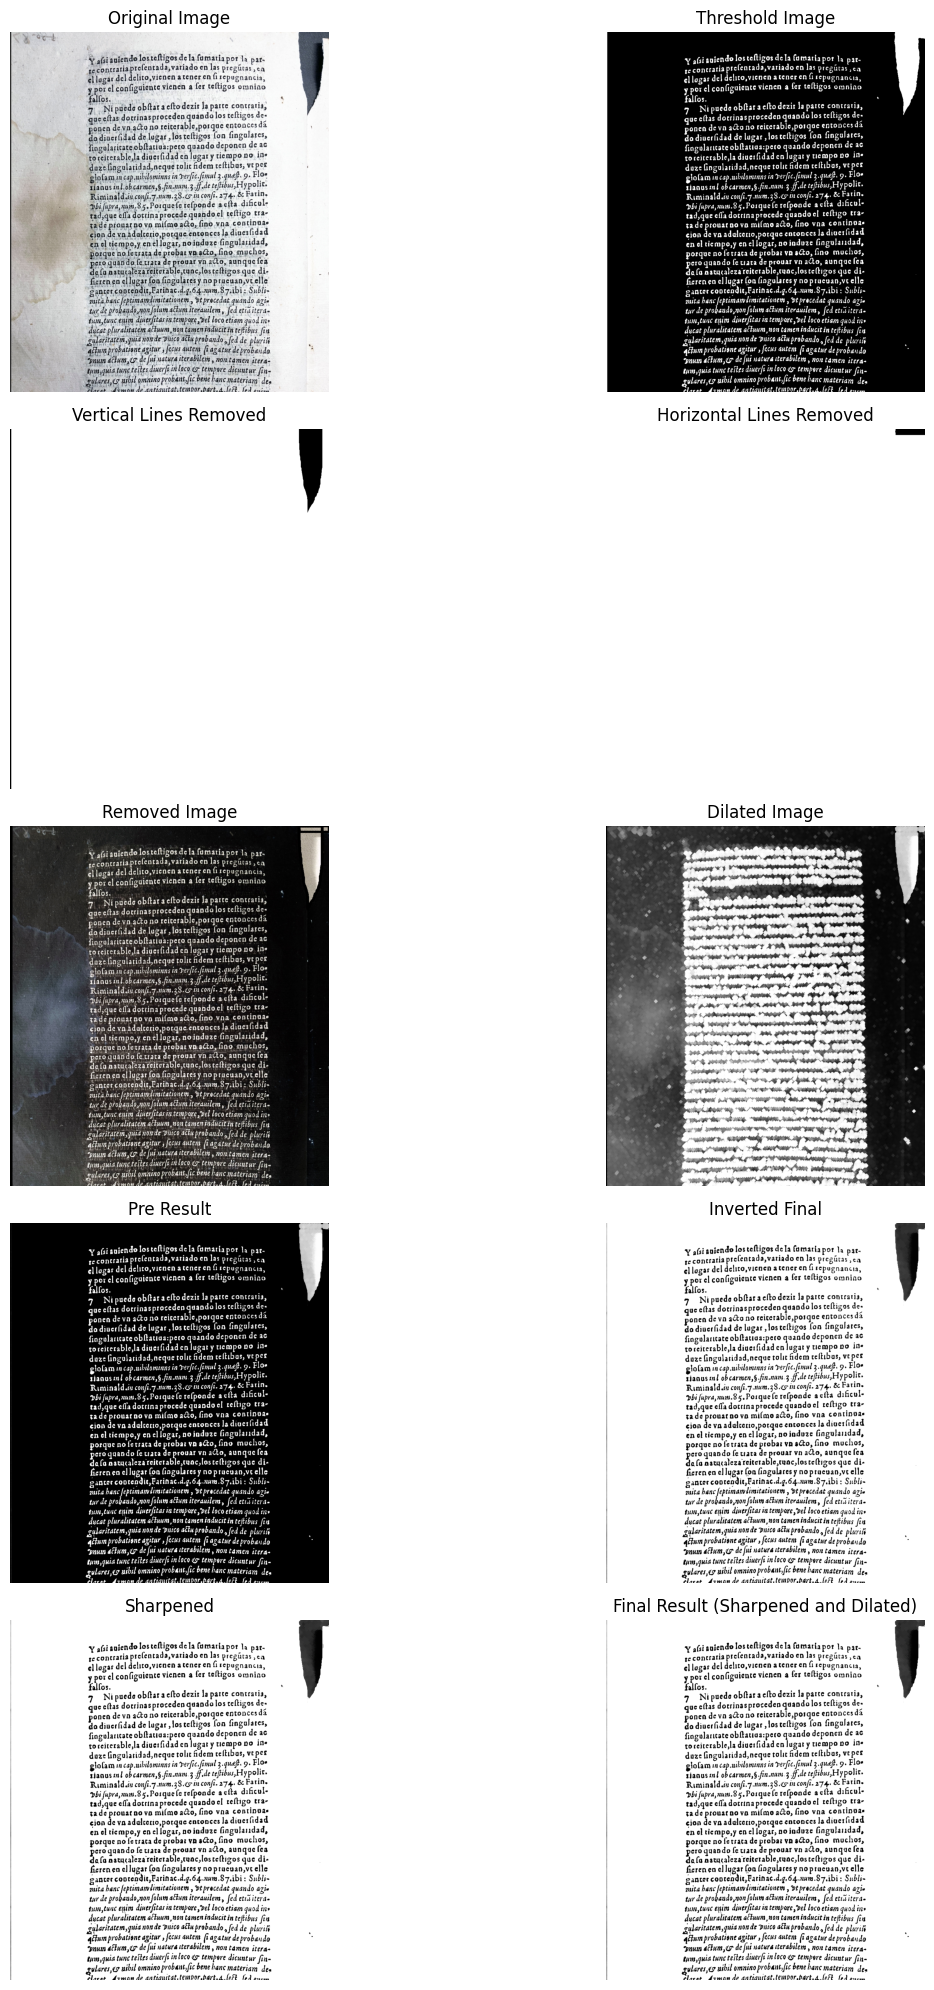

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('/content/2.jpeg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply denoising
gray = cv2.fastNlMeansDenoising(gray, None, 30, 7, 21)

# Apply binary thresholding using Otsu's method
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Copy the original image to preserve it
removed = image.copy()

# Remove vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
remove_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(removed, [c], -1, (255, 255, 255), 7)

# Remove horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
remove_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(removed, [c], -1, (255, 255, 255), 5)

# Repair kernel
repair_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
removed = 255 - removed
dilate = cv2.dilate(removed, repair_kernel, iterations=5)
dilate = cv2.cvtColor(dilate, cv2.COLOR_BGR2GRAY)
pre_result = cv2.bitwise_and(dilate, thresh)

# Final result
result = cv2.morphologyEx(pre_result, cv2.MORPH_CLOSE, repair_kernel, iterations=5)
final = cv2.bitwise_and(result, thresh)

# Invert the final image
invert_final = 255 - final

# Sharpening (reduced intensity)
blurred = cv2.GaussianBlur(invert_final, (3, 3), sigmaX=3, sigmaY=3)
sharpened = cv2.addWeighted(invert_final, 1.5, blurred, -0.5, 0)

# Morphological dilation to thicken the text
dilate_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
dilated = cv2.dilate(sharpened, dilate_kernel, iterations=1)

# Plotting each step
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(thresh, cmap='gray')
axes[1].set_title('Threshold Image')
axes[1].axis('off')

axes[2].imshow(255 - remove_vertical, cmap='gray')
axes[2].set_title('Vertical Lines Removed')
axes[2].axis('off')

axes[3].imshow(255 - remove_horizontal, cmap='gray')
axes[3].set_title('Horizontal Lines Removed')
axes[3].axis('off')

axes[4].imshow(cv2.cvtColor(removed, cv2.COLOR_BGR2RGB))
axes[4].set_title('Removed Image')
axes[4].axis('off')

axes[5].imshow(dilate, cmap='gray')
axes[5].set_title('Dilated Image')
axes[5].axis('off')

axes[6].imshow(pre_result, cmap='gray')
axes[6].set_title('Pre Result')
axes[6].axis('off')

axes[7].imshow(invert_final, cmap='gray')
axes[7].set_title('Inverted Final')
axes[7].axis('off')

axes[8].imshow(sharpened, cmap='gray')
axes[8].set_title('Sharpened')
axes[8].axis('off')

axes[9].imshow(dilated, cmap='gray')
axes[9].set_title('Final Result (Sharpened and Dilated)')
axes[9].axis('off')

plt.tight_layout()
plt.show()

# Save the final image
cv2.imwrite('final_result_improved.png', dilated)
cv2.imwrite('final_result_inv.png', invert_final)
cv2.imwrite('thresh.png', (255-thresh))